<a href="https://colab.research.google.com/github/manyasha-n-m/Tutorials/blob/main/Practical_Session_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Linear Regression (two dimensions):  Toy problem for warm-up**
Our observed ground truth is:
$$
y_t = 2x^1_t-3x^2_t+1, \quad t\in\{1,\dots,30\}
$$


#### Main task:

Assume that we only have information only about the 'observations' $(x_t,y_t)_{t\in\{1,\dots,30\}}$. However, we have a 'hypothesis' is that our model $\hat{~y~}$ depends on $x=(x^1_t,x^2_t)$ linearly, i.e.

$$
\hat{~y~}(x) = w^1 x^1+w^2 x^2+b
$$

Given the 'observations'  we need to recover the weights $w^1=2, w^2=-3$ and the bias $b = 1$.

### Strategy:

In order to do so, we will solve the following optimization problem:
$$
\underset{w^1,w^2,b}{\operatorname{argmin}} \frac{1}{30}\sum_{t=1}^{30} \left(\hat{~y~}(x_t)-y_t\right)^2 = \underset{w^1,w^2,b}{\operatorname{argmin}} loss(w, b)
$$


In this notebook/lecture we will focus on **optimization** of this so-called "Loss function" defined in the formula above.

In [1]:
# importing necessary libraries for this session

import numpy as np
from numpy.random import random
import jax
import jax.numpy as jnp
import torch
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

#### Generating random input data

In [2]:
# generate random input x
x = random((30,2))

# generate labels y corresponding to input data x according to our law
y = np.dot(x, [2., -3.]) + 1.
w_source = np.array([2., -3.])
b_source  = np.array([1.])

n_samples = len(y)

#### 2D Plotting tools

In [3]:
def plot_figs(fig_num, elev, azim, x, y, weights, bias):
    fig = plt.figure(fig_num, figsize=(4, 3))
    ax = plt.axes(projection='3d')
    ax.view_init(elev=elev, azim=azim)
    ax.scatter(x[:, 0], x[:, 1], y)
    ax.plot_surface(np.array([[0, 0], [1, 1]]),
                    np.array([[0, 1], [0, 1]]),
                    (np.dot(np.array([[0, 0, 1, 1],
                                      [0, 1, 0, 1]]).T, weights) + bias).reshape((2, 2)),
                    alpha=.5)
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.set_zlabel('y')
    return fig.show()

def plot_views(x, y, w, b):
    #Generate the different figures from different views
    elev = 43.5
    azim = -110
    return plot_figs(1, elev, azim, x, y, w, b[0])


### How our toy-data looks like

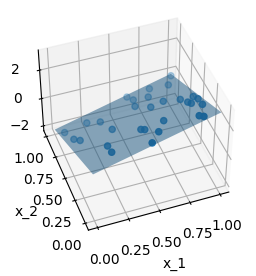

In [4]:
plot_views(x, y, w_source, b_source)

## **A few words about Gradient Descent**

Typically, for solving optimization problems one may need to use the ideas of Gradient Descent. In modern libraries, there already exist fancy methods for computing gradients recursively, however, today we will see how the basic idea can be implemented by hand.

#### Let's consider a simple example-illustration of a function in 1D to see how Gradient Descent works.

Suppose we need to minimize a function
$$f(t) = t^2 - 2t - 3$$

#### **Algorithm (with _rate_ $\alpha>0$ ):**

`1.` Choose initial point point $t_0$

`2.` Iteratively perform the "descent step", meaning:
$$t_{new} = t_{old} - \alpha f'(t_{old})$$

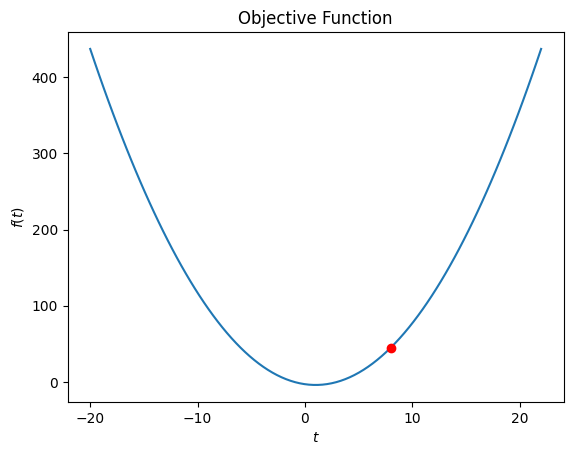

In [5]:
# plotting tools
def plotFunc(t0, t_int, function): #initial point (our first example t0 = -8) and a function
    plt.plot(t_int, function(t_int)) # plot the graph of the function
    plt.plot(t0, function(t0), 'ro') #plot a red dot on the initial condition
    plt.xlabel('$t$') # make the x-axis (and label it t)
    plt.ylabel('$f(t)$') #make the y-axis (and label it f(t))
    plt.title('Objective Function') #title of the picture/graph that we create

def plotPath(xs, ys, x0, x_int, function):
    plotFunc(x0, x_int, function)
    plt.plot(xs, ys, linestyle='--', marker='o', color='orange')
    plt.plot(xs[-1], ys[-1], 'ro')

# define the objective function
f = lambda t: t**2 - 2*t - 3
f_prime = lambda t: 2*t - 2

# define the initial point and the interval
t_0 = 8
t_int = np.linspace(-20, 22, 100)

# Initial stage
plotFunc(t_0, t_int, f)

### Let's see how simple Gradient Descent performs in 1D

Solution found:
  f_min = -4.0000
  t_min = 1.0000


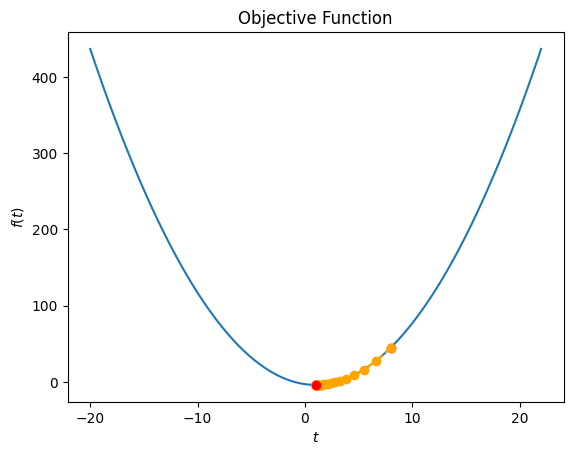

In [6]:
# 1D trivial implementation
def GradientDescentSimple(func, fprime, t0, alpha, tol=1e-5, max_iter=1000):
    # initialize x, f(x), and -f'(x)
    tk = t0
    fk = func(tk)
    pk = fprime(tk) #fprime(t0)
    # initialize number of steps, save t and f(t)
    num_iter = 0
    curve_t = [tk]
    curve_f = [fk]
    # take steps
    while abs(pk) > tol and num_iter < max_iter:
        # calculate new x, f(x), and -f'(x)
        tk = tk - alpha * pk  # x1 = x0 - alpha*derivative_of_function(tk)
        fk = func(tk) #fk = f(xk)
        pk = fprime(tk) #derivative of f at tk
        # increase number of steps by 1, save new t and f(t)
        num_iter += 1
        curve_t.append(tk) #save the curve t0 to tk
        curve_f.append(fk) #save the values f(t0) to f(tk)
    # print results / stopping criteria
    if num_iter == max_iter:
        print('Gradient descent does not converge.')
    else:
        print('Solution found:\n  f_min = {:.4f}\n  t_min = {:.4f}'.format(fk, tk))

    return curve_t, curve_f

ts, fs = GradientDescentSimple(f, f_prime, t_0, alpha=0.1)
plotPath(ts, fs, t_0, t_int, f)

### What if we choose a smaller $\alpha$?

Gradient descent does not converge.


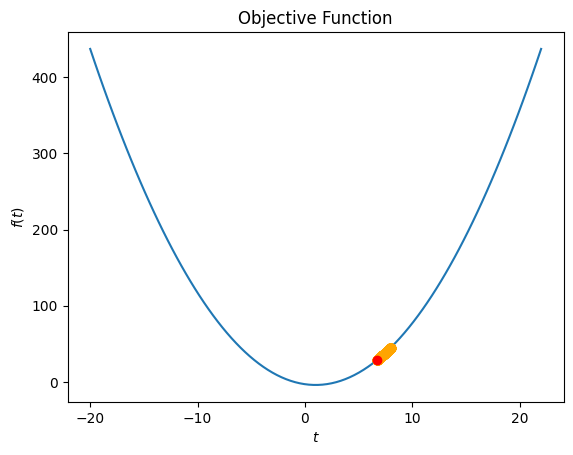

In [7]:
ts, fs = GradientDescentSimple(f, f_prime, t_0, alpha=0.0001)
plotPath(ts, fs, t_0, t_int, f)

### Bigger $\alpha$?

Solution found:
  f_min = -4.0000
  t_min = 1.0000


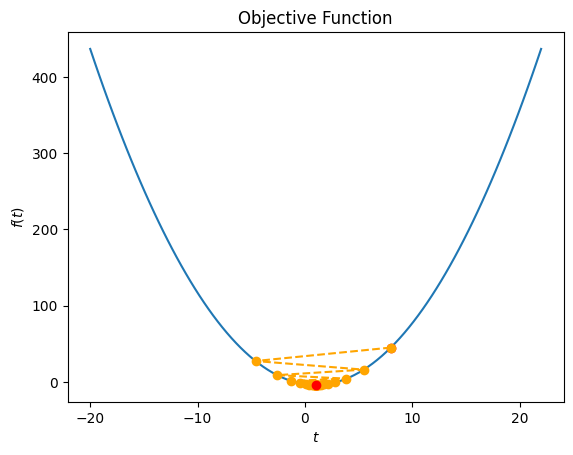

In [8]:
ts, fs = GradientDescentSimple(f, f_prime, t_0, alpha=0.9)
plotPath(ts, fs, t_0, t_int, f)

### Can $\alpha$ be too big?

Gradient descent does not converge.


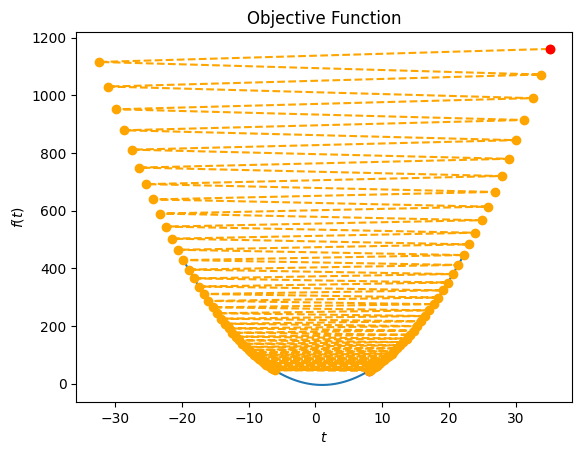

In [9]:
ts, fs = GradientDescentSimple(f, f_prime, t_0, alpha=1.01, max_iter=80)
plotPath(ts, fs, t_0, t_int, f)

## **Back to OUR model**

### How do we use the Gradient Descent for Linear Regression? What does the optimization step **looks** like?

In vector form, we define our hypothetical model:
$$
\hat{~y~}({ x}) = { w}^T{x}+b
$$
and we want to minimize the loss given by:
$$
loss = \frac{1}{30}\sum_t\underbrace{\left(\hat{~y~}({x_t})-y_t \right)^2}_{loss_t}.
$$

To minimize the loss we first compute the gradient of each $loss_t$:
\begin{align*}
\frac{\partial{loss_t}}{\partial w^1} &=& 2x^1_t\left({w}^T{x}_t+b-y_t \right)\\
\frac{\partial{loss_t}}{\partial w^2} &=& 2x^2_t\left({w}^T{x}_t+b-y_t \right)\\
\frac{\partial{loss_t}}{\partial b} &=& 2\left({w}^T{x}_t+b-y_t \right)
\end{align*}

Note that the actual gradient of the loss is given by:
$$
\frac{\partial{loss}}{\partial w^1} =\frac{1}{30}\sum_t \frac{\partial{loss_t}}{\partial w^1},\quad
\frac{\partial{loss}}{\partial w^2} =\frac{1}{30}\sum_t \frac{\partial{loss_t}}{\partial w^2},\quad
\frac{\partial{loss}}{\partial b} =\frac{1}{30}\sum_t \frac{\partial{loss_t}}{\partial b}
$$

For one epoch, **(Batch) Gradient Descent** updates the weights and bias as follows:
\begin{align*}
w^1_{new}&=&w^1_{old}-\alpha\frac{\partial{loss}}{\partial w^1} \\
w^2_{new}&=&w^2_{old}-\alpha\frac{\partial{loss}}{\partial w^2} \\
b_{new}&=&b_{old}-\alpha\frac{\partial{loss}}{\partial b},
\end{align*}

and then we run several epochs.

In [17]:
# randomly initialize learnable weights and bias
w_init = np.zeros(2)
b_init = np.array([0.])

w = w_init
b = b_init
print("initial values of the parameters:", w, b )

initial values of the parameters: [0. 0.] [0.]


In [18]:
# our model forward pass
def forward(x):
    return x.dot(w)+b

# Loss function
def loss_t(x, y):
    y_pred = forward(x)
    return (y_pred - y)**2

# compute gradient
def gradient(x, y):  # d_loss/d_w, d_loss/d_b
    return 2*(x.dot(w)+b - y)*x, 2 * (x.dot(w)+b - y)



loss_progress = []
print("initial loss:", np.mean([loss_t(x_val,y_val) for x_val, y_val in zip(x, y)]))


initial loss: 1.627052996872523


In [19]:
learning_rate = 0.1 # set the value of \alpha

# Training loop
for epoch in range(100):
  grad_w = np.array([0,0])
  grad_b = np.array(0)
  l = 0
  for x_val, y_val in zip(x, y):
    grad = gradient(x_val, y_val)
    grad_w = np.add(grad_w, grad[0])
    grad_b = np.add(grad_b, grad[1])
    l += loss_t(x_val, y_val)
  w = w - learning_rate * grad_w / n_samples
  b = b - learning_rate * grad_b / n_samples
  loss_progress.append(l[0] /n_samples )
  if epoch%10 == 0:
    print("progress:", "epoch:", epoch, "loss", loss_progress[-1])

# After training
print("estimation of the parameters:", "w =",w, ", b =", b)

progress: epoch: 0 loss 1.627052996872523
progress: epoch: 10 loss 0.8411504818620059
progress: epoch: 20 loss 0.5837540190674982
progress: epoch: 30 loss 0.40655242262816316
progress: epoch: 40 loss 0.2842751570898716
progress: epoch: 50 loss 0.19970851084287716
progress: epoch: 60 loss 0.14106477712136098
progress: epoch: 70 loss 0.10026684859740825
progress: epoch: 80 loss 0.07177595689435583
progress: epoch: 90 loss 0.051790435521537816
estimation of the parameters: w = [ 1.91973569 -2.32931946] , b = [0.68712361]


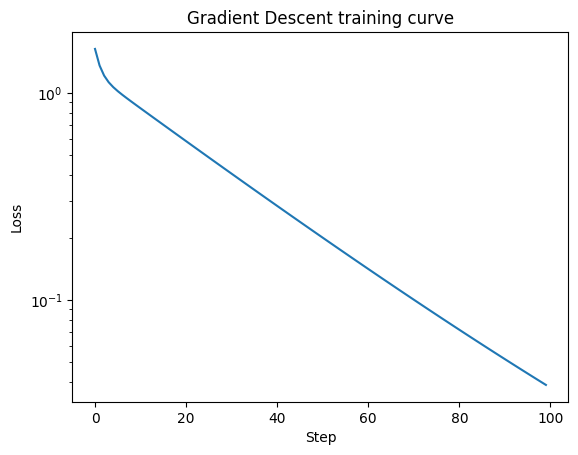

In [20]:
plt.plot(loss_progress)

plt.xlabel("Step")
plt.yscale("log")
plt.ylabel("Loss")
plt.title("Gradient Descent training curve")
plt.show()

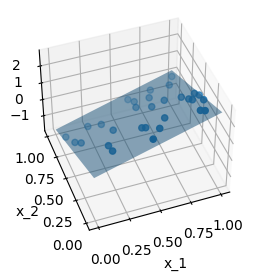

In [21]:
plot_views(x, y, w, b)

## **Linear regression using JAX**

In [22]:
# model weights
params = {
    'w': jnp.zeros(w_init.shape),
    'b': 0.
}

def jax_forward(params, X):
    return jnp.dot(X, params['w']) + params['b']


def jax_loss_fn(params, X, y):
    err = jax_forward(params, X) - y
    return jnp.mean(jnp.square(err))


grad_fn = jax.grad(jax_loss_fn)

def jax_update(params, grads):
    return jax.tree_map(lambda p, g: p - learning_rate * g, params, grads)

jax_loss_progress = []

# the main training loop
for epoch in range(100):
    loss = jax_loss_fn(params, x, y)
    jax_loss_progress.append(loss)

    grads = grad_fn(params, x, y)
    params = jax_update(params, grads)
    if epoch%10 == 0:
      print("progress:", "epoch:", epoch, "loss", loss)

<ipython-input-22-f9f6faac5fc1>:19: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(lambda p, g: p - learning_rate * g, params, grads)


progress: epoch: 0 loss 1.627053
progress: epoch: 10 loss 0.8411505
progress: epoch: 20 loss 0.58375406
progress: epoch: 30 loss 0.40655243
progress: epoch: 40 loss 0.28427517
progress: epoch: 50 loss 0.1997085
progress: epoch: 60 loss 0.14106476
progress: epoch: 70 loss 0.1002668
progress: epoch: 80 loss 0.07177594
progress: epoch: 90 loss 0.05179041


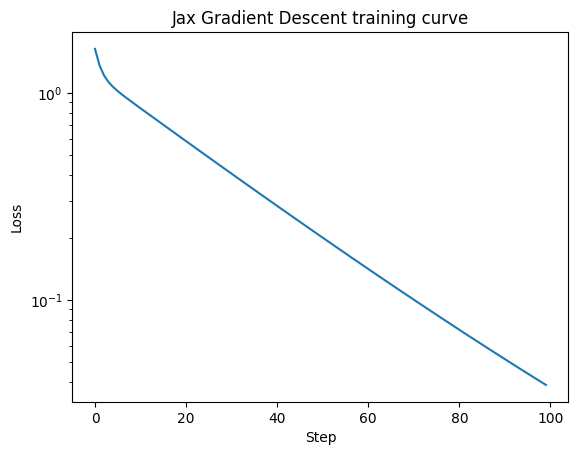

In [23]:
plt.plot(jax_loss_progress)

plt.xlabel("Step")
plt.yscale("log")
plt.ylabel("Loss")
plt.title("Jax Gradient Descent training curve")
plt.show()

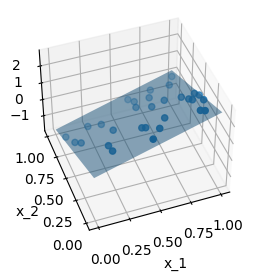

In [24]:
plot_views(x, y, params['w'], [params['b']])

## **Writing the same code using Pytorch (tensors)**

In [25]:
## Linear regression with tensors
dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU

x_t = torch.from_numpy(x).type(dtype)
y_t = torch.from_numpy(y).type(dtype).unsqueeze(1)

w_init_t = torch.from_numpy(w_init).type(dtype)
b_init_t = torch.from_numpy(b_init).type(dtype)

w_t = w_init_t.clone()
w_t.unsqueeze_(1)
b_t = b_init_t.clone()
b_t.unsqueeze_(1)
print("initial values of the parameters:", w_t, b_t )

# our model forward pass
def torch_forward(x):
    return x.mm(w_t)+b_t

# Loss function
def torch_loss(x, y):
    y_pred = torch_forward(x)
    return (y_pred - y).pow(2).sum()

# compute gradient
def torch_gradient(x, y):  # d_loss/d_w, d_loss/d_b
    return 2*torch.mm(torch.t(x),x.mm(w_t)+b_t - y), 2 * (x.mm(w_t)+b_t - y).sum()


torch_loss_progress = []

initial values of the parameters: tensor([[0.],
        [0.]]) tensor([[0.]])


In [26]:
for epoch in range(100):
    l_t = torch_loss(x_t,y_t) / n_samples
    grad_w, grad_b = torch_gradient(x_t,y_t)
    w_t = w_t-learning_rate*grad_w / n_samples
    b_t = b_t-learning_rate*grad_b / n_samples
    torch_loss_progress.append(l_t)

    if epoch%10 == 0:
      print("progress:", "epoch:", epoch, "loss", l_t)

# After training
print("estimation of the parameters:", w_t, b_t )

progress: epoch: 0 loss tensor(1.6271)
progress: epoch: 10 loss tensor(0.8412)
progress: epoch: 20 loss tensor(0.5838)
progress: epoch: 30 loss tensor(0.4066)
progress: epoch: 40 loss tensor(0.2843)
progress: epoch: 50 loss tensor(0.1997)
progress: epoch: 60 loss tensor(0.1411)
progress: epoch: 70 loss tensor(0.1003)
progress: epoch: 80 loss tensor(0.0718)
progress: epoch: 90 loss tensor(0.0518)
estimation of the parameters: tensor([[ 1.9197],
        [-2.3293]]) tensor([[0.6871]])


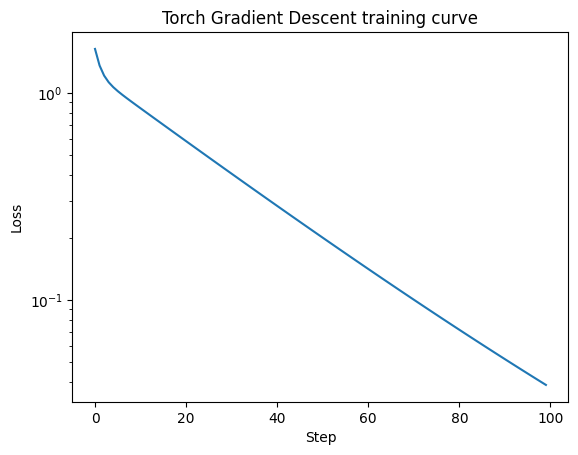

In [27]:
plt.plot(torch_loss_progress)

plt.xlabel("Step")
plt.yscale("log")
plt.ylabel("Loss")
plt.title("Torch Gradient Descent training curve")
plt.show()

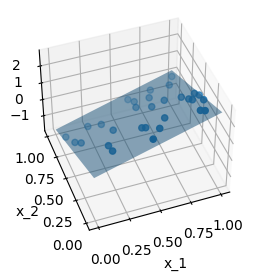

In [28]:
plot_views(x, y, w_t.numpy(), b_t.numpy())

## **Solving Linear regression explicitly with the Neural Network approach (with Torch)**

In [31]:
# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Variables for its weight and bias.
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1),
)

for m in model.children():
    m.weight.data = w_init_t.clone().unsqueeze(0)
    m.bias.data = b_init_t.clone()

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')

# switch to train mode
model.train()

for epoch in range(100):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Variable of input data to the Module and it produces
    # a Variable of output data.
    y_pred = model(x_t)

    # Note this operation is equivalent to: pred = model.forward(x_v)

    # Compute and print loss. We pass Variables containing the predicted and true
    # values of y, and the loss function returns a Variable containing the
    # loss.
    loss = loss_fn(y_pred, y_t)

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Variables with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its data and gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param.data -= 0.01 * param.grad

    if epoch%10 == 0:
      print("progress:", "epoch:", epoch, "loss",loss.data.item())

# After training
print("estimation of the parameters:")
for param in model.parameters():
    print(param)

progress: epoch: 0 loss 48.811588287353516
progress: epoch: 10 loss 11.947160720825195
progress: epoch: 20 loss 4.071608543395996
progress: epoch: 30 loss 1.4750956296920776
progress: epoch: 40 loss 0.5815420150756836
progress: epoch: 50 loss 0.25315332412719727
progress: epoch: 60 loss 0.12132497131824493
progress: epoch: 70 loss 0.06283756345510483
progress: epoch: 80 loss 0.03434266522526741
progress: epoch: 90 loss 0.01940653659403324
estimation of the parameters:
Parameter containing:
tensor([[ 2.0407, -2.9413]], requires_grad=True)
Parameter containing:
tensor([0.9421], requires_grad=True)


# **Introducing some stochasticity**

#### In the examples above you have seen different implementations of the same "brutal-force" Gradient Descent algorithm. In the example below, we may see how we can simplify the computational complexity via Stochastic Gradient Method.

The main difference in this case lies in the fact that instead of using the full set of observations $(x_t, y_t)_{t\in \{1,...,30\}}$, at each optimisation step we will randomly batch $N$ samples and consider a new loss function.

The optimization step for our example may look like this:

`1.` Sample the indexes $(i_1, ..., i_N)\subset \{1,.., 30\}$.

`2.` Construst the loss function
$$
loss_{sampled} = \frac{1}{N}\sum_{i_k=i_1}^{i_N}\left(\hat{~y~}(x_{i_k})-y_{i_k} \right)^2.$$

`3.` Perform the standard GD step using the above sampled loss function.


# **Assignment: (one-dimensional) Linear and Polynomial Regression**

Here is a list of things we can prectice today. The goal of this practical session is for you all to try out different tools for solving linear regression.

## *Important:* Do not hesitate to ask all the questions that you have, I am very happy to assist.

### **Linear Regression**

`1.` Generate some data $x = (x_t)_t$, each $x_t\in\mathbb{R}$ (~ 50 points).

`2.` Choose come coefficients $w$ and $b$ to construct a ground truth $y_t = wx_t +b$.

`3.` Apply the previous methodology to estimate $w,b\in\mathbb{R}$ approximating these 50 data points via Gradient Descent implementations (using the examples above).

progress: epoch: 0 loss 114.269844
progress: epoch: 10 loss 0.31005096


<ipython-input-68-f27526c7b720>:27: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(lambda p, g: p - learning_rate * g, params, grads)


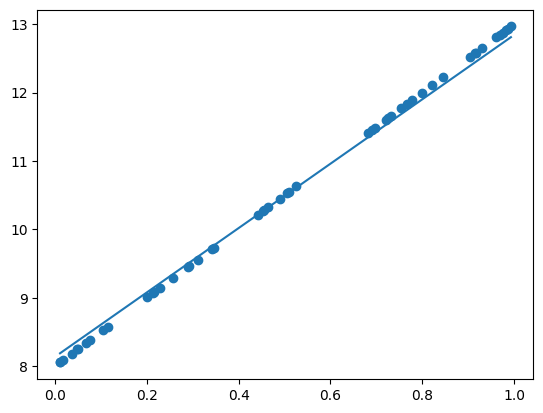

In [68]:
"""Write your code here"""

learning_rate = 0.01

# FAST SOLUTION via JAX (Linear regression in 1D)


x = random(50)
y = 5*x +8

# model initial weights
params = {
    'w': 0.,
    'b': 0.
}

def jax_forward(params, X):
    return jnp.dot(X, params['w']) + params['b']


def jax_loss_fn(params, X, y):
    err = jax_forward(params, X) - y
    return jnp.mean(jnp.square(err))


grad_fn = jax.grad(jax_loss_fn)

def jax_update(params, grads):
    return jax.tree_map(lambda p, g: p - learning_rate * g, params, grads)

jax_loss_progress = []

# the main training loop
for epoch in range(20):
    loss = jax_loss_fn(params, x, y)
    jax_loss_progress.append(loss)

    grads = grad_fn(params, x, y)
    params = jax_update(params, grads)
    if epoch%10 == 0:
      print("progress:", "epoch:", epoch, "loss", loss)

plt.figure()
plt.scatter(x, y) # my model prediction
interval = np.linspace(x.min(), x.max(), 100)
plt.plot(interval, params['w']*interval + params['b']) # my model prediction

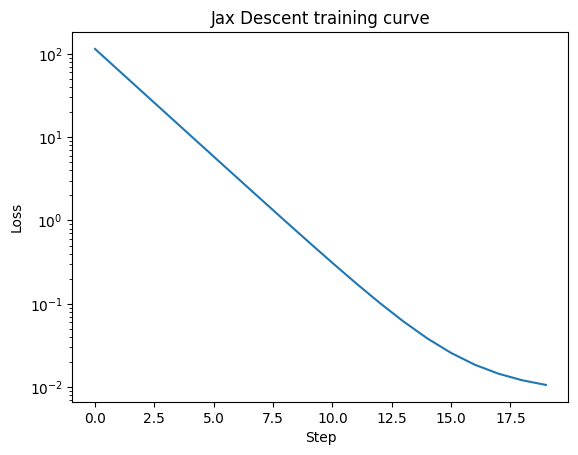

In [69]:
# let's also verify that the loss function is decreasing
plt.plot(jax_loss_progress)

plt.xlabel("Step")
plt.yscale("log")
plt.ylabel("Loss")
plt.title("Jax Descent training curve")
plt.show()

### **Regression for polynomial of degree 2**

`1.` Now assume that our ground truth model will have a form
$$
f_{t}(x) = w_2 x^2_t+ w_1x_t +w_0, \quad t\in\{1,\dots,50\}
$$
for some fixed $w_0, w_1, w_2\in\mathbb{R}$.

`2.` Use the Gradient Descent methods to approximate your model by

$$
\hat{~f~}_{t}(x) = \hat{~w~}_2 x^2_t+ \hat{~w~}_1x_t +\hat{~w~}_0, \quad t\in\{1,\dots,50\}
$$

### _Can we use the same loss function?_

<ipython-input-70-9ba8219e74dd>:27: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(lambda p, g: p - learning_rate * g, params, grads)


progress: epoch: 0 loss 132.83266
progress: epoch: 10 loss 0.17463735
progress: epoch: 20 loss 0.025152916
progress: epoch: 30 loss 0.016401332
progress: epoch: 40 loss 0.011085444
progress: epoch: 50 loss 0.007801869
progress: epoch: 60 loss 0.0057706893
progress: epoch: 70 loss 0.004511368
progress: epoch: 80 loss 0.0037278037
progress: epoch: 90 loss 0.003237437


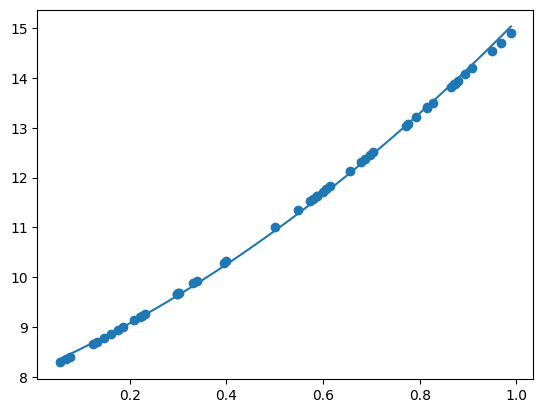

In [70]:
"""Write your code here"""

# FAST SOLUTION via JAX (Polynomial regression of degree 2 in 1D)

x = random(50)
y = 2* x**2 + 5*x + 8

# model initial weights
params = {
    'q': 0.,
    'w': 0.,
    'b': 0.
}
# that way my model is y_hat = q * x^2 + w * x + b

def jax_forward(params, X):
    return (X**2)* params['q']+ X * params['w'] + params['b']

def jax_loss_fn(params, X, y):
    err = jax_forward(params, X) - y
    return jnp.mean(jnp.square(err))

grad_fn = jax.grad(jax_loss_fn)

def jax_update(params, grads):
    return jax.tree_map(lambda p, g: p - learning_rate * g, params, grads)

jax_loss_progress = []

# the main training loop
for epoch in range(100):
    loss = jax_loss_fn(params, x, y)
    jax_loss_progress.append(loss)

    grads = grad_fn(params, x, y)
    params = jax_update(params, grads)
    if epoch%10 == 0:
      print("progress:", "epoch:", epoch, "loss", loss)

plt.figure()
plt.scatter(x, y) # my true observations
interval = np.linspace(x.min(), x.max(), 100)
plt.plot(interval, params['q']* (interval**2) + params['w']*interval + params['b']) # my model prediction

### **Regression for polynomial of degree 3**

`1.` Now repeat the same analysis having a new ground truth model
$$
g_{t}(x) = w_3 x^3 + w_2 x^2_t+ w_1x_t +w_0, \quad t\in\{1,\dots,50\}
$$
for some fixed $w_0, w_1, w_2, w_3\in\mathbb{R}$.


<ipython-input-71-b6b94daf3c6b>:27: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  return jax.tree_map(lambda p, g: p - learning_rate * g, params, grads)


progress: epoch: 0 loss 160.36322
progress: epoch: 10 loss 0.136307
progress: epoch: 20 loss 0.032082528
progress: epoch: 30 loss 0.014834721
progress: epoch: 40 loss 0.0070771864
progress: epoch: 50 loss 0.0035788177
progress: epoch: 60 loss 0.0019974755
progress: epoch: 70 loss 0.0012790853
progress: epoch: 80 loss 0.00094923866
progress: epoch: 90 loss 0.0007944195


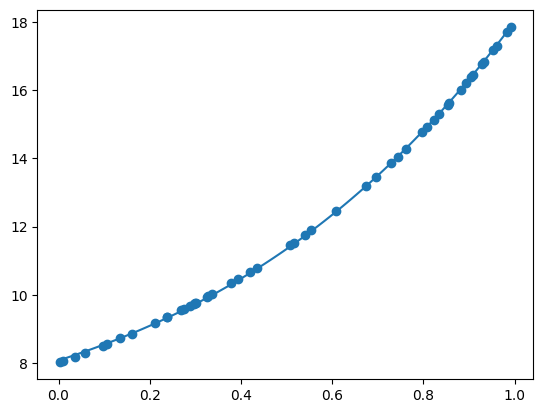

In [71]:
"""Write your code here"""

# FAST SOLUTION via JAX (Polynomial regression of degree 3 in 1D)

x = random(50)
y = 3* x**3 + 2* x**2 + 5*x + 8

# model initial weights
params = {
    'm': 0.,
    'q': 0.,
    'w': 0.,
    'b': 0.
}
# that way my model is y_hat = m * x^3 + q * x^2 + w * x + b

def jax_forward(params, X):
    return (X**3) * params['m'] + (X**2) * params['q']+ X * params['w'] + params['b']

def jax_loss_fn(params, X, y):
    err = jax_forward(params, X) - y
    return jnp.mean(jnp.square(err))

grad_fn = jax.grad(jax_loss_fn)

def jax_update(params, grads):
    return jax.tree_map(lambda p, g: p - learning_rate * g, params, grads)

jax_loss_progress = []

# the main training loop
for epoch in range(100):
    loss = jax_loss_fn(params, x, y)
    jax_loss_progress.append(loss)

    grads = grad_fn(params, x, y)
    params = jax_update(params, grads)
    if epoch%10 == 0:
      print("progress:", "epoch:", epoch, "loss", loss)

plt.figure()
plt.scatter(x, y) # my true observations
interval = np.linspace(x.min(), x.max(), 100)
plt.plot(interval, params['m']* (interval**3) + params['q']* (interval**2) + params['w']*interval + params['b']) # my model prediction

**Hint-idea for the polynomial regression tasks:** Given the 'observations' $(x_t,f_{t}(x_t))_{t\in\{1,\dots,50\}}$ (in the second case) and $(x_t,g_{t}(x_t))_{t\in\{1,\dots,50\}}$ (in the third case) recover the weights and the bias like we would do for the Linear Regression.


## **P.S.**
Above you see the exercises. However, for scientific curiosity, you may play with those a bit more. Here are some extra ideas:

- Try to write your own version of `plot_views` function to plot the samples $(y_t, x_t)$, (and later $(f_t, x_t)$, $(g_t, x_t)$) to compare how well your trained model imitates it.
- Play with the learning rate of your model, see "how fast" (how many iterations is needed) we converge to the solution.
- Try to implement the SGD approach for our one-dimentional examples, or for any of the examples above. Suggestion, use `jax`.

____
By Nataliia Monina